<a href="https://colab.research.google.com/github/IndraP24/Skin-Cancer-Detector/blob/main/sc_detector/notebooks/Skin_Cancer_Classification_Custom_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Cancer Classification



In [ ]:
!nvidia-smi

Mon May  3 03:33:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [1]:
#import the important libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd
import datetime
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, Dense
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

The data is obtained from Kaggle. The data loading from Kaggle is shown below.

There are 7 Classes in that data as follows: 
 
0: Actinic keratoses and intraepithelial carcinoma / Bowen's disease >> `akiec`
 
1: Dermatofibroma >> `df`

2: Benign keratosis-like lesions >> `bkl`

3: Melanoma >> `mel`

4: Melanocytic nevi >> `nv`

5: Vascular lesions >> `vasc`

6: Basal cell carcinoma >> `bcc`


# Loading data using Kaggle API

In [ ]:
# Create a directory called ".kaggle"
!mkdir ~/.kaggle

In [ ]:
# Place the kaggle.json file in the directory
!cp kaggle.json ~/.kaggle/

In [ ]:
# Set permissions of 600 ---> which means that the owner has full read and write access to the file, while no other user can access the file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Search for the ham10000 dataset in kaggle datasets
! kaggle datasets list -s ham10000

ref                                               title                                            size  lastUpdated          downloadCount  
------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  
kmader/skin-cancer-mnist-ham10000                 Skin Cancer MNIST: HAM10000                       5GB  2018-09-20 20:36:13          39633  
tschandl/ham10000-lesion-segmentations            HAM10000 Lesion Segmentations                    10MB  2020-07-02 21:20:22            190  
andrewmvd/isic-2019                               Skin Lesion Images for Melanoma Classification    9GB  2020-05-28 05:11:34           2105  
artakusuma/basedir                                HAM10000 Preprocessed Data                        6GB  2019-03-17 05:03:33             60  
tsaideepak/skin-cancer                            skin cancer                                     462MB  2019-03-23 19:39:19            452  
discdi

In [ ]:
# Download the ham10000 dataset
! kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [01:48<00:00, 110MB/s]
100% 5.20G/5.20G [01:48<00:00, 51.3MB/s]


In [ ]:
# Unzip images and place them in a directory
!mkdir skin-cancer-mnist-ham10000
!unzip /content/skin-cancer-mnist-ham10000.zip -d skin-cancer-mnist-ham10000

# Reading a specific csv file

In [ ]:
df = pd.read_csv('../content/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
df = df.sample(frac = 1) # randomize the data
data = df.iloc[:,:-1] # extract the pixel data
labels = df.iloc[:,-1:] # extract the corresponding labels
df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,pixel0010,pixel0011,pixel0012,pixel0013,pixel0014,pixel0015,pixel0016,pixel0017,pixel0018,pixel0019,pixel0020,pixel0021,pixel0022,pixel0023,pixel0024,pixel0025,pixel0026,pixel0027,pixel0028,pixel0029,pixel0030,pixel0031,pixel0032,pixel0033,pixel0034,pixel0035,pixel0036,pixel0037,pixel0038,pixel0039,...,pixel2313,pixel2314,pixel2315,pixel2316,pixel2317,pixel2318,pixel2319,pixel2320,pixel2321,pixel2322,pixel2323,pixel2324,pixel2325,pixel2326,pixel2327,pixel2328,pixel2329,pixel2330,pixel2331,pixel2332,pixel2333,pixel2334,pixel2335,pixel2336,pixel2337,pixel2338,pixel2339,pixel2340,pixel2341,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
5111,245,170,178,245,172,182,247,174,184,246,170,179,246,169,177,245,167,174,245,165,172,245,164,169,244,159,162,243,155,158,246,160,158,246,161,161,247,167,172,247,...,242,171,168,243,172,169,244,174,168,244,174,169,242,172,167,242,172,166,240,170,163,241,171,164,240,170,163,240,171,163,239,171,164,235,167,162,232,164,158,4
1191,250,191,185,251,184,175,250,179,175,251,182,184,254,189,196,254,189,195,254,187,189,254,189,195,253,189,199,252,186,192,252,189,194,251,189,197,253,193,205,252,...,241,182,184,244,186,187,243,183,185,243,180,184,239,182,181,239,183,183,240,182,185,242,184,189,242,189,191,245,194,195,243,192,190,238,188,186,240,186,185,3
1724,87,58,51,117,87,82,138,109,103,147,112,107,153,116,111,161,125,130,166,129,135,168,127,136,173,136,145,174,131,140,175,130,138,173,121,129,171,117,122,169,...,201,166,163,202,168,170,202,166,170,199,164,164,200,171,171,197,170,167,191,160,153,187,156,146,186,160,152,179,152,138,171,144,129,171,150,145,165,146,139,6
9997,93,62,91,168,118,150,189,131,161,190,139,163,190,148,168,189,147,162,194,156,176,196,155,174,199,161,184,205,172,190,204,172,185,208,176,196,206,173,195,203,...,198,157,176,200,162,182,196,153,168,190,140,146,193,150,162,193,153,169,191,153,174,192,156,181,196,159,182,190,138,166,189,138,174,171,130,163,91,59,86,0
5168,194,98,112,199,100,120,202,107,126,198,104,122,186,98,115,211,118,136,211,119,138,211,118,139,215,123,143,213,118,136,208,114,126,198,105,119,197,103,121,212,...,201,112,115,196,108,108,198,114,111,203,121,120,200,114,111,200,115,111,202,120,116,205,127,123,198,119,116,191,110,110,194,110,113,194,114,114,191,117,116,4


In [ ]:
labels.head(30)

,label
5111,4
1191,3
1724,6
9997,0
5168,4
6652,4
1882,6
3966,4
9049,4
5395,4


# Data distribution

[Text(0, 0, 'akiec'),
 Text(0, 0, 'df'),
 Text(0, 0, 'bkl'),
 Text(0, 0, 'mel'),
 Text(0, 0, 'nv'),
 Text(0, 0, 'vasc'),
 Text(0, 0, 'bcc')]

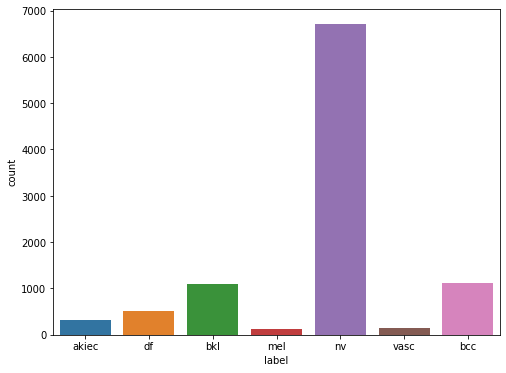

In [ ]:
type_of_cancer = ['akiec','df','bkl','mel','nv','vasc','bcc']
counts = list(labels.value_counts())
plt.figure(figsize = (8,6))
ax = sns.countplot(x='label', data=df)
ax.set_xticklabels(type_of_cancer)

The data is heavily imbalanced which leads to a significant effect on the values of metrics

We do the following for resolving the problem:

1. We duplicated the other classes "randomly " other than `nv` class (Data Duplication)


2. Generate new images with 'ImageDataGenarator' from Keras (Data Augmentation)

In [ ]:
df = df.sort_values('label') # Sorting the data according to the labels
df = df.reset_index()

In [ ]:
df

,index,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,pixel0010,pixel0011,pixel0012,pixel0013,pixel0014,pixel0015,pixel0016,pixel0017,pixel0018,pixel0019,pixel0020,pixel0021,pixel0022,pixel0023,pixel0024,pixel0025,pixel0026,pixel0027,pixel0028,pixel0029,pixel0030,pixel0031,pixel0032,pixel0033,pixel0034,pixel0035,pixel0036,pixel0037,pixel0038,...,pixel2313,pixel2314,pixel2315,pixel2316,pixel2317,pixel2318,pixel2319,pixel2320,pixel2321,pixel2322,pixel2323,pixel2324,pixel2325,pixel2326,pixel2327,pixel2328,pixel2329,pixel2330,pixel2331,pixel2332,pixel2333,pixel2334,pixel2335,pixel2336,pixel2337,pixel2338,pixel2339,pixel2340,pixel2341,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,9992,112,81,85,116,83,88,123,86,94,129,91,98,138,97,107,145,98,113,150,98,112,154,96,106,163,107,121,170,117,133,171,108,116,172,114,122,177,135,147,...,174,132,158,172,130,158,168,129,159,168,122,150,166,110,135,163,106,128,160,106,131,151,96,119,144,96,114,136,86,106,127,76,96,109,62,81,75,37,52,0
1,9853,170,121,121,171,124,121,180,137,139,181,137,140,180,139,142,185,147,153,187,151,155,185,148,150,186,149,152,186,150,156,185,149,153,186,149,152,186,150,153,...,186,149,147,187,151,151,185,147,145,180,137,130,184,145,141,183,146,141,181,143,135,180,143,137,176,137,130,181,145,144,181,148,150,181,149,150,178,146,146,0
2,9707,249,213,234,249,212,230,251,219,240,245,206,217,242,200,208,242,199,205,234,191,195,239,198,208,235,190,190,241,200,206,233,186,181,218,168,154,230,186,180,...,237,198,192,239,200,199,238,198,196,241,204,205,240,203,196,236,197,185,240,202,194,241,204,198,237,201,193,239,200,193,240,202,198,244,209,210,240,205,205,0
3,9762,185,140,145,192,148,155,192,146,155,195,149,161,190,135,148,194,138,157,197,145,161,197,145,160,197,144,165,199,148,167,200,153,172,196,143,168,200,152,176,...,189,132,148,191,138,154,187,135,149,181,125,139,178,121,133,172,112,126,175,122,138,181,135,151,176,127,141,168,115,130,171,121,136,160,106,116,154,99,111,0
4,9743,166,128,118,168,125,120,180,144,142,189,160,154,195,166,162,197,167,166,199,169,166,203,171,170,205,178,177,207,178,176,208,177,175,210,181,180,202,168,168,...,215,187,183,212,181,178,203,162,154,208,174,172,210,182,181,203,169,169,192,150,149,185,139,137,188,146,144,180,137,129,170,121,109,162,108,94,157,103,92,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,2226,4,1,3,32,14,21,124,88,107,191,156,184,207,169,203,204,157,187,204,157,188,203,158,185,207,162,187,207,163,183,208,168,187,208,165,182,204,157,170,...,197,141,128,194,139,123,199,146,140,198,147,143,199,151,153,199,152,158,199,152,162,195,148,160,197,154,174,182,141,160,119,79,95,31,13,17,4,1,3,6
10011,1406,193,162,192,194,164,195,192,161,191,191,158,184,193,161,188,193,159,188,194,154,187,194,151,187,195,160,195,197,168,201,196,167,197,197,170,202,198,174,213,...,198,168,202,197,167,195,197,166,191,196,164,185,195,160,177,198,162,191,198,159,197,200,164,204,198,160,196,193,147,176,191,145,169,192,143,176,192,142,173,6
10012,2293,140,93,83,160,121,124,167,131,139,171,138,145,174,140,145,178,148,152,184,156,167,184,152,159,181,145,147,189,158,164,193,163,175,193,164,177,196,168,181,...,194,164,174,196,168,184,192,161,175,191,158,168,186,149,153,187,155,160,189,161,170,188,162,172,181,151,160,181,152,165,179,152,167,174,146,159,146,117,127,6
10013,1595,105,89,99,128,114,127,139,122,133,130,102,100,150,121,128,158,133,144,163,140,154,162,142,156,153,127,132,173,155,166,183,166,183,180,162,175,186,169,183,...,175,144,160,174,141,158,179,155,170,182,165,181,183,170,184,173,153,158,173,156,162,172,154,164,168,150,158,162,145,151,149,124,124,142,118,12

# Data Duplication

Here we duplicate the class of the data for some amount of times.

The 4th index is ignored as it is the imbalanced class.

In [ ]:
index0 = df[df['label'] == 0].index.values
index1 = df[df['label'] == 1].index.values
index2 = df[df['label'] == 2].index.values
index3 = df[df['label'] == 3].index.values
index5 = df[df['label'] == 5].index.values
index6 = df[df['label'] == 6].index.values

In [ ]:

df0 = df.iloc[int(min(index0)):int(max(index0)+1)]
df1 = df.iloc[int(min(index1)):int(max(index1)+1)]
df2 = df.iloc[int(min(index2)):int(max(index2)+1)]
df3 = df.iloc[int(min(index3)):int(max(index3)+1)]
df5 = df.iloc[int(min(index5)):int(max(index5)+1)]
df6 = df.iloc[int(min(index6)):int(max(index6)+1)]


We have taken some random optimal values to centralize the new data which contains the duplicated data along with the previous data.

In [ ]:

df_index0 = df0.append([df0]*17, ignore_index = True)
df_index1 = df1.append([df1]*15, ignore_index = True)
df_index2 = df2.append([df2]*5, ignore_index = True)
df_index3 = df3.append([df3]*52, ignore_index = True)
df_index5 = df5.append([df5]*45, ignore_index = True)
df_index6 = df6.append([df6]*5, ignore_index = True)

frames = [df, df_index0, df_index1, df_index2, df_index3, df_index5, df_index6]

In [ ]:
# Concatenating all the feature dataframes to form the final dataframe
final_df = pd.concat(frames)
final_df.drop('index', inplace = True, axis = 1)
final_df = final_df.sample(frac = 1)
data = final_df.iloc[:,:-1]
labels = final_df.iloc[:,-1:]

### We can now see that The Distribution of The  classes are more Normalized and More Balanced

[Text(0, 0, 'akiec'),
 Text(0, 0, 'df'),
 Text(0, 0, 'bkl'),
 Text(0, 0, 'mel'),
 Text(0, 0, 'nv'),
 Text(0, 0, 'vasc'),
 Text(0, 0, 'bcc')]

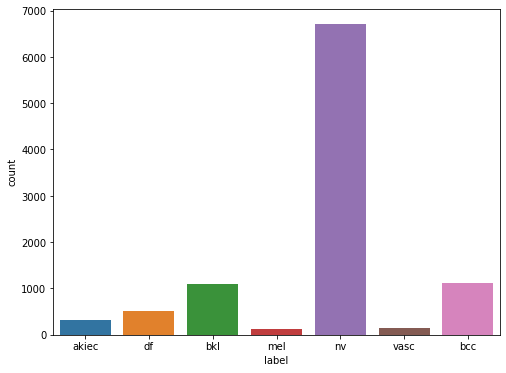

In [ ]:
type_of_cancer = ['akiec','df','bkl','mel','nv','vasc','bcc']
counts = list(labels.value_counts())
plt.figure(figsize = (8,6))
ax = sns.countplot(x='label', data=df)
ax.set_xticklabels(type_of_cancer)

# Image data preprocessing

Now we can divide the data. 

X : feature "for the data "

Y : labels "for the lables"





In [ ]:
X = np.array(data)
Y = np.array(labels)

## Reshaping the data

In [ ]:

X = X.reshape(-1,28,28,3)

print( X.shape)
print( Y.shape)

(50024, 28, 28, 3)
(50024, 1)


## Normalizing the data 

In [ ]:
X = (X-np.mean(X))/np.std(X)

## Splitting the data into train and the test data

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

print( X_train.shape)
print( X_test.shape)
print( Y_train.shape)
print( Y_test.shape)



(40019, 28, 28, 3)
(10005, 28, 28, 3)
(40019, 1)
(10005, 1)


# Data Augmentation with ImageDataGenerator

In [ ]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
train_datagen.fit(X_train)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen.fit(X_test)

train_data = train_datagen.flow(X_train, Y_train, batch_size = 64)
test_data = test_datagen.flow(X_test, Y_test, batch_size = 64)

# Modeling

## Model architecture

In [ ]:
model = Sequential([
    
    Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'),
    Conv2D(32, kernel_size = (3,3), activation = 'relu'),
    MaxPool2D(pool_size = (2,2)),

    Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    MaxPool2D(pool_size = (2,2), padding = 'same'),

    Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    MaxPool2D(pool_size = (2,2), padding = 'same'),

    Flatten(),
    
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')]
)


### Adjusting learning rate and the optimizer 

In [ ]:

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00075,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8)

In [ ]:

model.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 64)          3

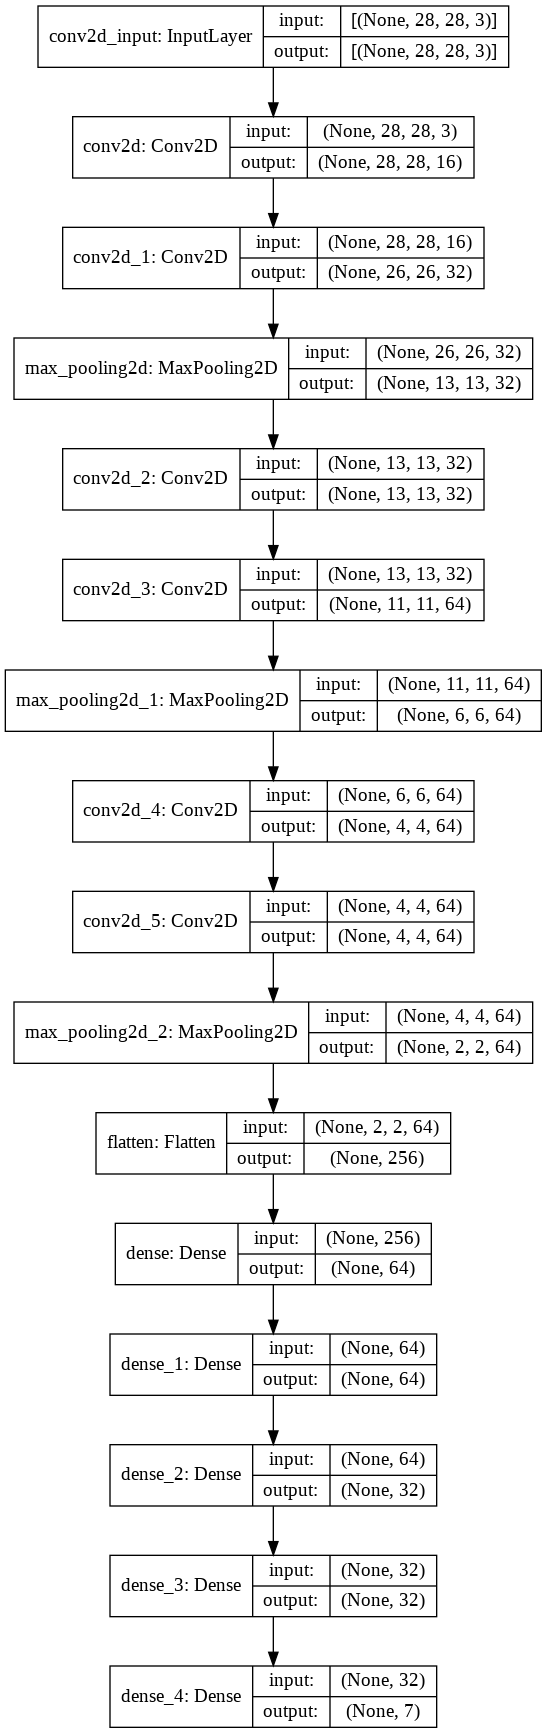

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Fitting the model

In [ ]:
epochs = 20

history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 64,
                    epochs = epochs,
                    callbacks=[learning_rate_reduction]) 

Epoch 1/20
501/501 [==============================] - 37s 8ms/step - loss: 1.5846 - accuracy: 0.3530 - val_loss: 0.9878 - val_accuracy: 0.6159
Epoch 2/20
501/501 [==============================] - 3s 6ms/step - loss: 0.8873 - accuracy: 0.6579 - val_loss: 0.6282 - val_accuracy: 0.7591
Epoch 3/20
501/501 [==============================] - 3s 6ms/step - loss: 0.5395 - accuracy: 0.7944 - val_loss: 0.4337 - val_accuracy: 0.8385
Epoch 4/20
501/501 [==============================] - 3s 6ms/step - loss: 0.3862 - accuracy: 0.8523 - val_loss: 0.2824 - val_accuracy: 0.8969
Epoch 5/20
501/501 [==============================] - 3s 6ms/step - loss: 0.2889 - accuracy: 0.8879 - val_loss: 0.2575 - val_accuracy: 0.9062
Epoch 6/20
501/501 [==============================] - 3s 6ms/step - loss: 0.2068 - accuracy: 0.9222 - val_loss: 0.2458 - val_accuracy: 0.9095
Epoch 7/20
501/501 [==============================] - 3s 6ms/step - loss: 0.1793 - accuracy: 0.9337 - val_loss: 0.2183 - val_accuracy: 0.9229
Epoch

# Model Evaluation on test data

In [ ]:
model_acc_test = model.evaluate(X_test, Y_test, verbose=0)[1]
print("the test model accuracy =",model_acc_test * 100)

the test model accuracy = 98.52073788642883


# Model Performance measures

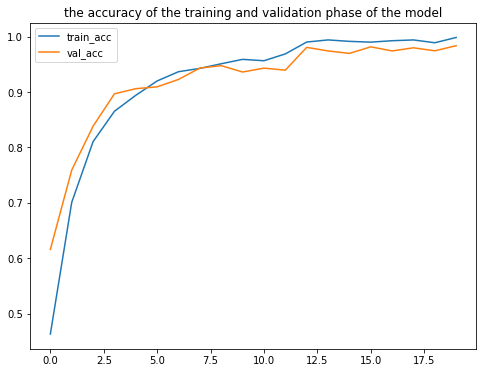

In [ ]:
ACC = history.history['accuracy']
VAL_ACC = history.history['val_accuracy']

plt.figure(figsize=(8,6))
plt.title("the accuracy of the training and validation phase of the model")
plt.plot(ACC, label = 'train_acc')
plt.plot(VAL_ACC, label = 'val_acc')
plt.legend()

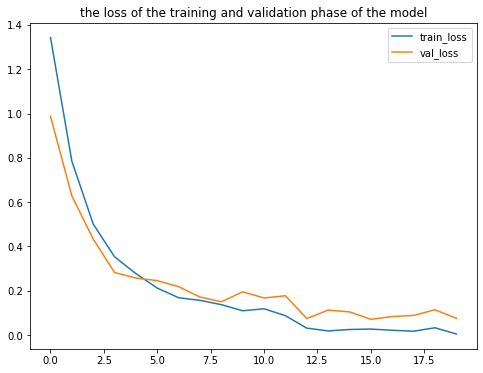

In [ ]:
LOSS = history.history['loss']
VAL_LOSS = history.history['val_loss']

plt.figure(figsize=(8,6))
plt.title("the loss of the training and validation phase of the model")
plt.plot(LOSS, label = 'train_loss')
plt.plot(VAL_LOSS, label = 'val_loss')
plt.legend()

## Confusion Matrix

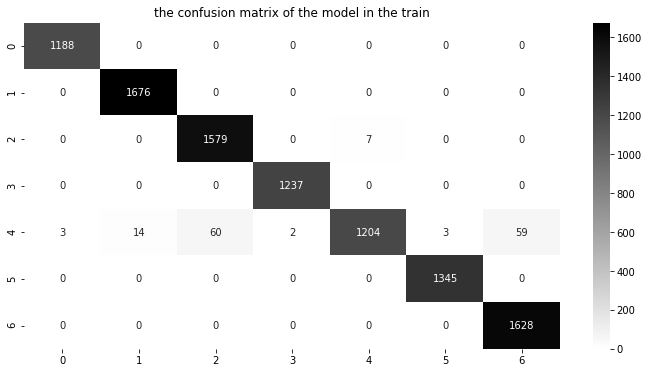

In [ ]:

Y_true = np.array(Y_test)

Y_pred = model.predict(X_test)
Y_pred = np.array(list(map(lambda x: np.argmax(x), Y_pred)))

cm1 = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 6))
plt.title('the confusion matrix of the model in the train')
sns.heatmap(cm1, annot = True, fmt = 'g' ,vmin = 0, cmap = 'binary')

# Classification report

- precision

- recall

- f1-score

- accuracy

In [ ]:
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}

classification_report_model = classification_report(Y_true, Y_pred, target_names=label_mapping.values())
print(classification_report_model)

              precision    recall  f1-score   support

          nv       1.00      1.00      1.00      1188
         mel       0.99      1.00      1.00      1676
         bkl       0.96      1.00      0.98      1586
         bcc       1.00      1.00      1.00      1237
       akiec       0.99      0.90      0.94      1345
        vasc       1.00      1.00      1.00      1345
          df       0.97      1.00      0.98      1628

    accuracy                           0.99     10005
   macro avg       0.99      0.98      0.99     10005
weighted avg       0.99      0.99      0.98     10005



# Saving the model for further use

In [ ]:
model.save('my_model.h5')